In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%run Data_manipulation.ipynb

# Loading data

In [3]:
NIFTY = pd.read_csv('D:/UFG/Data collection/NIFTY.csv')
NIFTY['Date']= pd.to_datetime(NIFTY['Date'], format='%Y-%m-%d')
scaled_data_NIFTY, scaler_NIFTY = scale_data(NIFTY)
df_residuals_NIFTY, df_trend_NIFTY, df_seasonal_NIFTY, decomposition_results_NIFTY = transform_to_stationary(scaled_data_NIFTY)
NIFTY.set_index('Date', inplace=True)
scaled_data_NIFTY.set_index('Date', inplace=True)

In [4]:
IBOV = pd.read_csv('D:/UFG/Data collection/IBOV.csv')
IBOV['Date']= pd.to_datetime(IBOV['Date'], format='%Y-%m-%d')
scaled_data_IBOV, scaler_IBOV = scale_data(IBOV)
df_residuals_IBOV, df_trend_IBOV, df_seasonal_IBOV, decomposition_results_IBOV = transform_to_stationary(scaled_data_IBOV)
IBOV.set_index('Date', inplace=True)
scaled_data_IBOV.set_index('Date', inplace=True)

In [5]:
# Align the data by merging on the date index
stationary_aligned_data = pd.merge(df_residuals_NIFTY['Close'], df_residuals_IBOV['Close'], left_index=True, right_index=True, suffixes=('_NIFTY', '_IBOV'))
stationary_aligned_data.head()

Close_NIFTY  Close_IBOV
Date                               
2000-07-05     0.006446    0.005937
2000-07-06     0.005409    0.007744
2000-07-07     0.004410    0.009596
2000-07-10     0.005001    0.012085
2000-07-11     0.006267    0.005462

<Axes: xlabel='Date'>

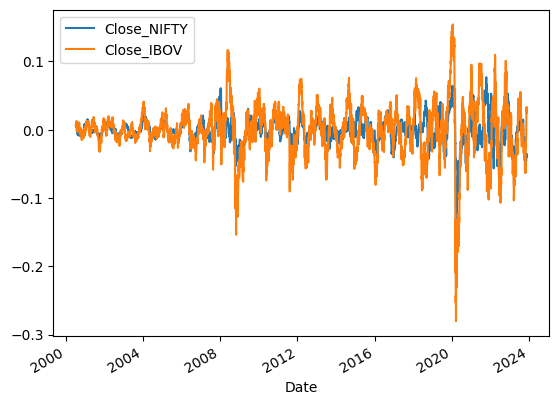

In [6]:
stationary_aligned_data.plot()

# Cross-corelation function

#### Check how correlated the index are with regards to another

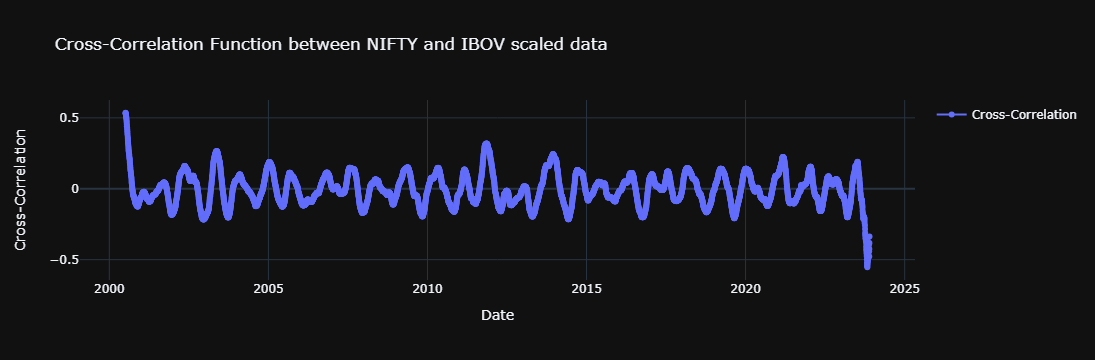

In [7]:
from statsmodels.tsa.stattools import ccf

# Calculate cross-correlation
cross_corr = ccf(stationary_aligned_data['Close_NIFTY'], stationary_aligned_data['Close_IBOV'])

# Generate date lags
dates = stationary_aligned_data.index
date_lags = dates[:len(cross_corr)]

# Create the plotly figure
fig = go.Figure()

# Add the cross-correlation function trace
fig.add_trace(go.Scatter(x=date_lags, y=cross_corr, mode='lines+markers', name='Cross-Correlation'))

# Update the layout
fig.update_layout(
    title='Cross-Correlation Function between NIFTY and IBOV scaled data',
    xaxis_title='Date',
    yaxis_title='Cross-Correlation',
    template='plotly_dark',
    showlegend=True
)

# Show the plot
fig.show()

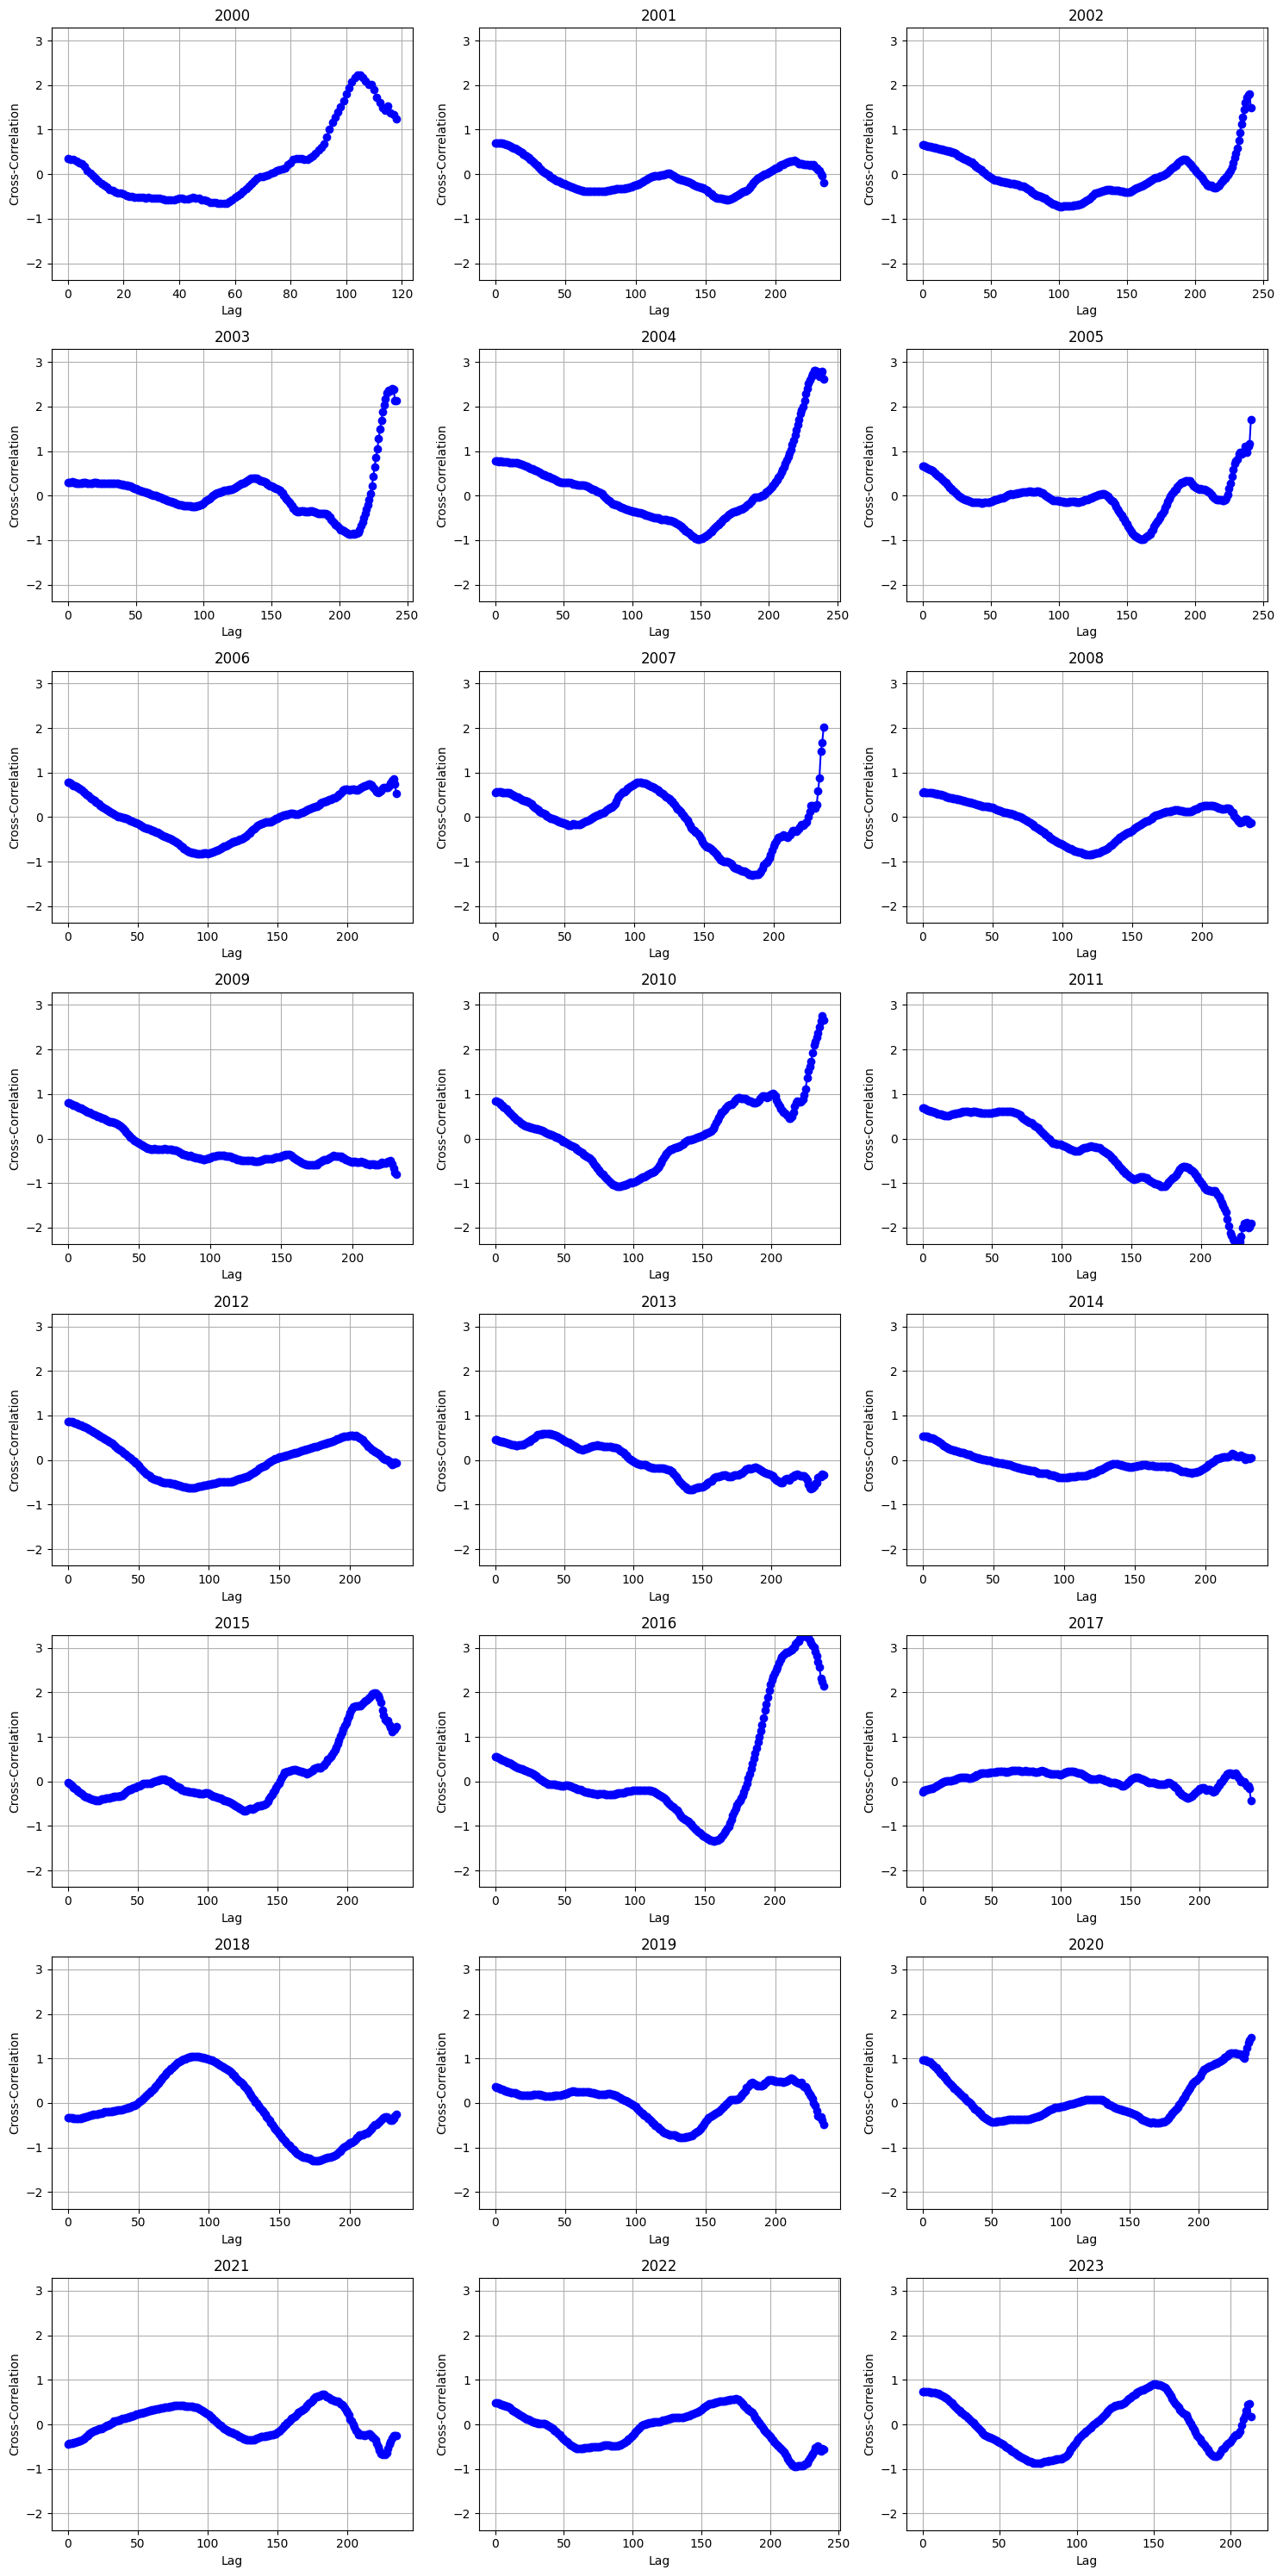

In [8]:
# Determine the number of years to plot
years = stationary_aligned_data.index.year.unique()
num_years = len(years)

# Calculate global min and max for y-axis limits
cross_corrs = []
for year, yearly_data in stationary_aligned_data.groupby(stationary_aligned_data.index.year):
    cross_corr = ccf(yearly_data['Close_NIFTY'], yearly_data['Close_IBOV'])
    cross_corrs.append(cross_corr)

# Flatten the list to find the global min and max
all_cross_corrs = np.concatenate(cross_corrs)
y_min, y_max = all_cross_corrs.min(), all_cross_corrs.max()

# Create a figure with a 3x8 grid
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(15, 30))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each year and plot the cross-correlation function
for i, (year, yearly_data) in enumerate(stationary_aligned_data.groupby(stationary_aligned_data.index.year)):
    # Calculate cross-correlation
    cross_corr = ccf(yearly_data['Close_NIFTY'], yearly_data['Close_IBOV'])
    
    # Generate lag indices
    lags = np.arange(len(cross_corr))
    
    # Plot on the corresponding subplot
    axes[i].plot(lags, cross_corr, marker='o', linestyle='-', color='b')
    axes[i].set_title(f'{year}')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Cross-Correlation')
    axes[i].grid(True)
    
    # Set consistent y-axis limits across all subplots
    axes[i].set_ylim(y_min, y_max)

# Hide any empty subplots if there are less than 24 years
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

#### *There are variation between the indics correlation (positive and negative), this lack of consistent correlation indicates some degree of interaction but one cannot predict the future movement solely based on past values of the another index*

# Granger Causality Test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.1338 , p=0.0000  , df_denom=5549, df_num=1
ssr based chi2 test:   chi2=37.1539 , p=0.0000  , df=1
likelihood ratio test: chi2=37.0301 , p=0.0000  , df=1
parameter F test:         F=37.1338 , p=0.0000  , df_denom=5549, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=85.1842 , p=0.0000  , df_denom=5546, df_num=2
ssr based chi2 test:   chi2=170.5220, p=0.0000  , df=2
likelihood ratio test: chi2=167.9553, p=0.0000  , df=2
parameter F test:         F=85.1842 , p=0.0000  , df_denom=5546, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=60.7907 , p=0.0000  , df_denom=5543, df_num=3
ssr based chi2 test:   chi2=182.6024, p=0.0000  , df=3
likelihood ratio test: chi2=179.6628, p=0.0000  , df=3
parameter F test:         F=60.7907 , p=0.0000  , df_denom=5543, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=46.3374 , p=0.

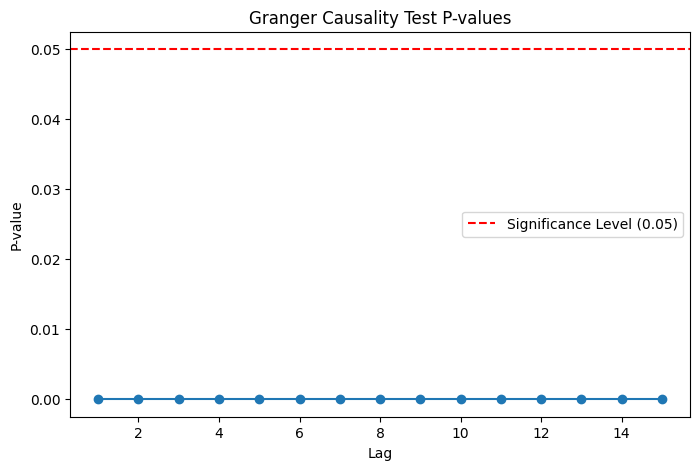

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Perform Granger Causality test
max_lag = 15  # Number of lags to test
granger_test_result = grangercausalitytests(stationary_aligned_data, max_lag, verbose=True)

# Extract p-values for each lag
p_values = [granger_test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]

# Plot the p-values
plt.figure(figsize=(8,5))
plt.plot(range(1, max_lag+1), p_values, marker='o')
plt.title('Granger Causality Test P-values')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.legend()
plt.show()


### *The test continues to show highly significant results, but the F-statistics progressively decrease from 6 to 15, which might indicate that while Granger causality is still detected, the predictive power of additional lagged terms diminishes after a few lags.*

# By Year

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Group data by year
grouped_data_by_year = stationary_aligned_data.groupby(stationary_aligned_data.index.year)

# Perform Granger Causality test for each year
max_lag = 15
for year, data in grouped_data_by_year:
    print(f"Performing Granger Causality test for the year: {year}")
    
    # Perform the Granger Causality test
    granger_test_result = grangercausalitytests(stationary_aligned_data, max_lag, verbose=False)
    
    # Extract p-values for each lag
    p_values = [granger_test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
    if max(p_values) < 0.05:
        print('Granger causality test hold for the stationary time series\n')


Performing Granger Causality test for the year: 2000
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2001
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2002
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2003
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2004
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2005
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2006
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2007
Granger causality test hold for the stationary time series

Performing Granger Causality test for the year: 2008
Granger causality test hold for the station

### *For each lag (from 1 to 15), there is Granger causality, that is one time series can predict another.*

### *Multiple test are used to find Granger causality, also as the number of lag increases chi-squared increases indicating more lag capture more dynamic relationship between two indices*

### *Important: CCF and Granger causality are contradicting relationship between indices. For Granger causality, it focuses on whether the inclusion of past values of one variable improves the prediction of the other variable(might have short term interaction) but in case of CCF,  It provides a broad overview of how two series might be related over various time lags but doesn't directly assess predictability.*

# T-test 

In [8]:
from scipy.stats import ttest_ind

# Calculate returns if necessary (if data represents prices)
stationary_aligned_data['Return_NIFTY'] = stationary_aligned_data['Close_NIFTY'].pct_change().dropna()
stationary_aligned_data['Return_IBOV'] = stationary_aligned_data['Close_IBOV'].pct_change().dropna()

# Drop NA values resulting from return calculation
returns_data = stationary_aligned_data.dropna(subset=['Return_NIFTY', 'Return_IBOV'])

# Perform pairwise t-test on returns
t_statistic, p_value = ttest_ind(returns_data['Return_NIFTY'], returns_data['Return_IBOV'])

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("The means of the two samples are significantly different.")
else:
    print("The means of the two samples are not significantly different.")


t-statistic: -0.4013145636024183
p-value: 0.6881962664541487
The means of the two samples are not significantly different.


### *Both time series data have their mean separated by -0.4013, and they are not statistical significant different*

# Vector AutoRegression (VAR) model

In [24]:
import pandas as pd
from statsmodels.tsa.api import VAR

# Fit the VAR model
model = VAR(stationary_aligned_data)

# Select the optimal lag length based on AIC
lag_order = model.select_order()
optimal_lag = lag_order.aic

# Fit the model with the selected lag length
var_model = model.fit(optimal_lag)

# Generate in-sample predictions
in_sample_predictions = var_model.fittedvalues

# Display the first few rows of the in-sample predictions
in_sample_predictions.head()

Close_NIFTY  Close_IBOV
Date                               
2000-08-17    -0.006549    0.005688
2000-08-18    -0.006126    0.007251
2000-08-21    -0.005855    0.004647
2000-08-22    -0.006201    0.000257
2000-08-23    -0.006506    0.001683

### *Using VAR model to fit NIFTY and IBOV data*

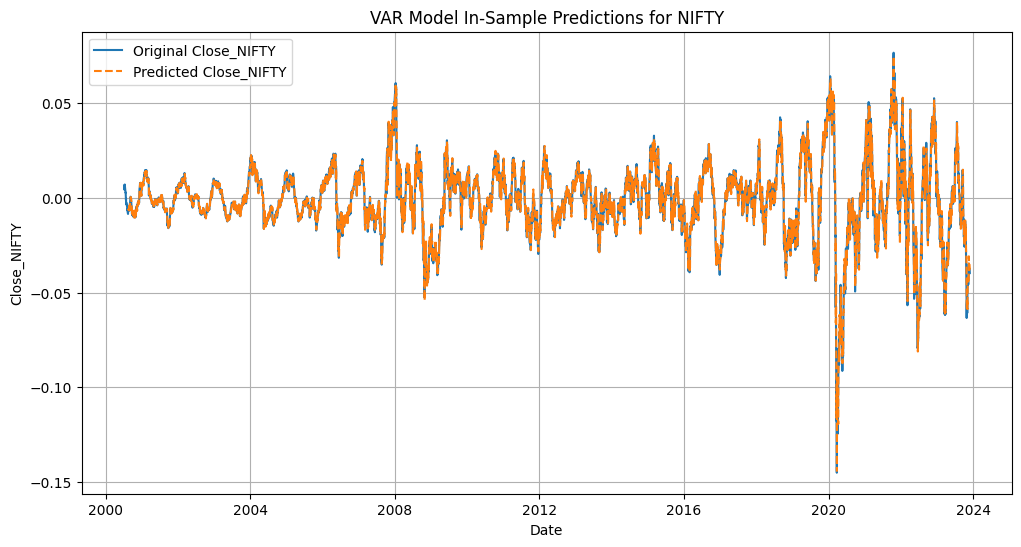

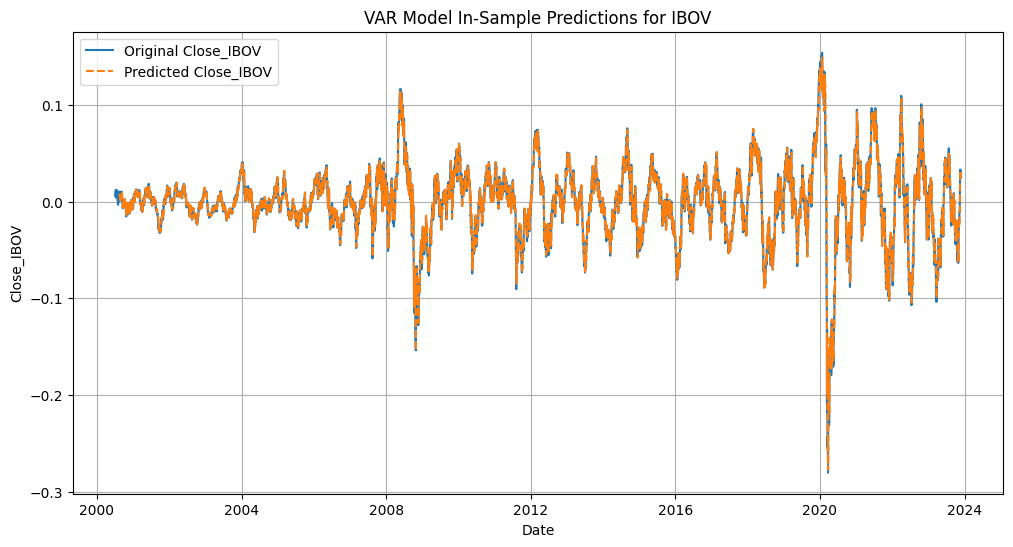

In [25]:
# Plotting the original and predicted values

# Plot for NIFTY
plt.figure(figsize=(12, 6))
plt.plot(stationary_aligned_data.index, stationary_aligned_data['Close_NIFTY'], label='Original Close_NIFTY')
plt.plot(in_sample_predictions.index, in_sample_predictions['Close_NIFTY'], label='Predicted Close_NIFTY', linestyle='--')
plt.legend()
plt.title('VAR Model In-Sample Predictions for NIFTY')
plt.xlabel('Date')
plt.ylabel('Close_NIFTY')
plt.grid(True)
plt.show()

# Plot for IBOV
plt.figure(figsize=(12, 6))
plt.plot(stationary_aligned_data.index, stationary_aligned_data['Close_IBOV'], label='Original Close_IBOV')
plt.plot(in_sample_predictions.index, in_sample_predictions['Close_IBOV'], label='Predicted Close_IBOV', linestyle='--')
plt.legend()
plt.title('VAR Model In-Sample Predictions for IBOV')
plt.xlabel('Date')
plt.ylabel('Close_IBOV')
plt.grid(True)
plt.show()

# Impluse Response function

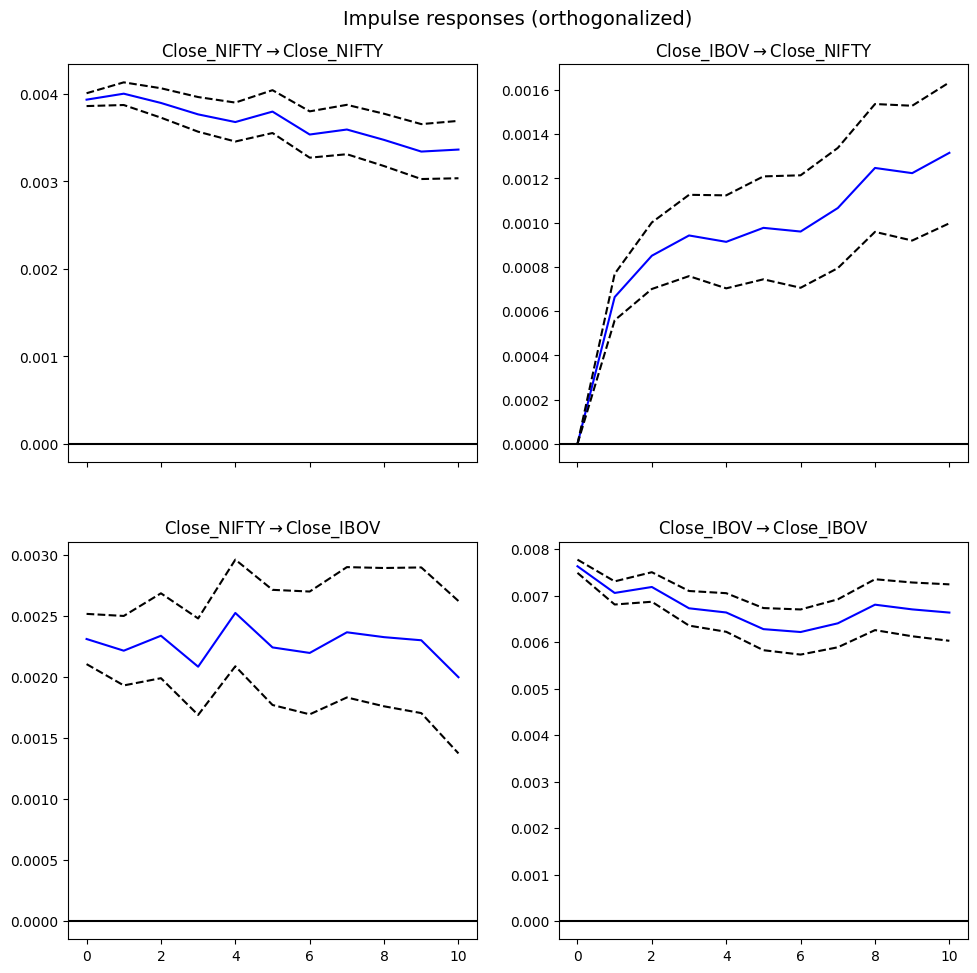

In [28]:
irf = var_model.irf(10)
irf.plot(orth=True)
plt.show()

### *Impluse response function shows shock wrt time series. The blue line indicates the magnitude of the response, and the dashed lines represent confidence intervals.*

### *We can observe that increase in IBOV also increases the NIFTY, other are relatively irresponsive to other time series*